In [17]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import copy
import torch
import torch.nn as nn
import torch.optim as optim

In [18]:
from IPython.display import clear_output
%matplotlib inline
import time

In [20]:
class GridMoveEnv(gym.Env):
    metadata = {"render_modes": ["human"], "render_fps": 4}

    def __init__(self, grid_size=10, render_mode=None):
        super().__init__()
        self.grid_size = grid_size
        self.render_mode = render_mode

        self.start_pos = np.array([0.0, 0.0], dtype=np.float32)
        self.goal_pos = np.array([grid_size - 1, grid_size - 1], dtype=np.float32)

        self.observation_space = spaces.Box(
            low=0.0, high=grid_size - 1, shape=(2,), dtype=np.float32
        )
        self.action_space = spaces.Box(
            low=0.0, high=grid_size - 1, shape=(2,), dtype=np.float32
        )

        self.state = self.start_pos.copy()
        self.visited = np.zeros((grid_size, grid_size), dtype=np.int32)

        # For rendering
        self.episode_number = 0

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.state = self.start_pos.copy()
        self.visited[:, :] = 0
        return self.state.copy(), {}

    def step(self, action):
        action = np.clip(action, 0.0, self.grid_size - 1)
        self.state = action.copy()

        x, y = int(round(self.state[0])), int(round(self.state[1]))
        self.visited[x, y] += 1

        dist = np.linalg.norm(self.state - self.goal_pos)
        reward = -dist

        terminated = dist < 1.0
        truncated = False
        self.episode_number += 1

        return self.state.copy(), reward, terminated, truncated, {}

    def render(self):
        clear_output(wait=True)
        fig, ax = plt.subplots()
        ax.set_xlim(-0.5, self.grid_size - 0.5)
        ax.set_ylim(-0.5, self.grid_size - 0.5)
        ax.set_xticks(np.arange(-0.5, self.grid_size, 1))
        ax.set_yticks(np.arange(-0.5, self.grid_size, 1))
        ax.grid(True)
        ax.set_aspect('equal')
        ax.invert_yaxis()
        agent_marker = patches.Circle((0, 0), 0.3, color='blue', label="Agent")
        goal_marker = patches.Rectangle(
            (self.goal_pos[1] - 0.5, self.goal_pos[0] - 0.5),
            1, 1, edgecolor='green', facecolor='green', alpha=0.5, label="Goal"
        )
        ax.add_patch(agent_marker)
        ax.add_patch(goal_marker)
        ax.legend()

        # Update agent marker position
        # add title with the episode number
        ax.set_title(f"Episode: {self.episode_number}")
        agent_marker.center = (self.state[1], self.state[0])
        plt.show();
        

    def close(self):
        #plt.ioff()
        if self.fig:
            plt.close(self.fig)
            self.fig = None
            self.ax = None


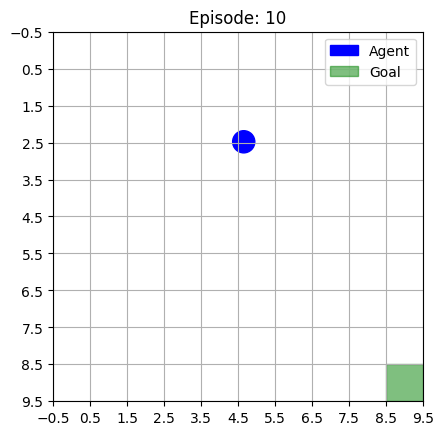

In [22]:
%matplotlib inline
env = GridMoveEnv(grid_size=10)
obs, _ = env.reset()
for _ in range(10):
    action = env.action_space.sample()
    next_obs, reward, terminated, truncated, _ = env.step(action)
    print(f"Obs: {obs}, Action: {action}, Next: {next_obs}, Reward: {reward:.2f}")
    env.render()
    time.sleep(0.1)
    #if terminated or truncated:
    #    break
    obs = next_obs

In [ ]:
# Hyperparameters
GAMMA = 0.99
TAU = 0.005
ACTOR_LR = 1e-4
CRITIC_LR = 1e-3
BUFFER_SIZE = int(1e6)
BATCH_SIZE = 256
START_TIMESTEPS = 10000
EXPL_NOISE = 0.1
MAX_EPISODES = 200
MAX_STEPS = 1000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Replay Buffer
class ReplayBuffer:
    def __init__(self, state_dim, action_dim, max_size=BUFFER_SIZE):
        self.ptr = 0
        self.size = 0
        self.max_size = max_size
        self.state = np.zeros((max_size, state_dim))
        self.next_state = np.zeros((max_size, state_dim))
        self.action = np.zeros((max_size, action_dim))
        self.reward = np.zeros((max_size, 1))
        self.done = np.zeros((max_size, 1))

    def add(self, state, action, reward, next_state, done):
        self.state[self.ptr] = state
        self.action[self.ptr] = action
        self.reward[self.ptr] = reward
        self.next_state[self.ptr] = next_state
        self.done[self.ptr] = float(done)
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size):
        ind = np.random.randint(0, self.size, size=batch_size)
        return (
            torch.FloatTensor(self.state[ind]).to(device),
            torch.FloatTensor(self.action[ind]).to(device),
            torch.FloatTensor(self.reward[ind]).to(device),
            torch.FloatTensor(self.next_state[ind]).to(device),
            torch.FloatTensor(self.done[ind]).to(device)
        )

# Actor Network
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super().__init__()
        self.l1 = nn.Linear(state_dim, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, action_dim)
        self.max_action = max_action

    def forward(self, x):
        x = torch.relu(self.l1(x))
        x = torch.relu(self.l2(x))
        return self.max_action * torch.tanh(self.l3(x))

# Critic Network (Q-function)
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.l1 = nn.Linear(state_dim + action_dim, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, 1)

    def forward(self, x, u):
        xu = torch.cat([x, u], dim=1)
        x = torch.relu(self.l1(xu))
        x = torch.relu(self.l2(x))
        return self.l3(x)

# DDPG Agent
class DDPGAgent:
    def __init__(self, state_dim, action_dim, max_action, env):
        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target = copy.deepcopy(self.actor)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=ACTOR_LR)

        self.critic = Critic(state_dim, action_dim).to(device)
        self.critic_target = copy.deepcopy(self.critic)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=CRITIC_LR)

        self.max_action = max_action
        self.replay_buffer = ReplayBuffer(state_dim, action_dim)

    def select_action(self, state):
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        return self.actor(state).cpu().data.numpy().flatten()

    def train(self):
        if self.replay_buffer.size < BATCH_SIZE:
            return

        state, action, reward, next_state, done = self.replay_buffer.sample(BATCH_SIZE)

        with torch.no_grad():
            target_action = self.actor_target(next_state)
            target_Q = self.critic_target(next_state, target_action)
            target_Q = reward + (1 - done) * GAMMA * target_Q

        # Critic update
        current_Q = self.critic(state, action)
        critic_loss = nn.MSELoss()(current_Q, target_Q)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Actor update
        actor_loss = -self.critic(state, self.actor(state)).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Soft update target networks
        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
            target_param.data.copy_(TAU * param.data + (1 - TAU) * target_param.data)

        for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
            target_param.data.copy_(TAU * param.data + (1 - TAU) * target_param.data)

# Main training loop
def train_ddpg(env, env_name="Experiment-v1"):
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])

    agent = DDPGAgent(state_dim, action_dim, max_action)

    total_timesteps = 0

    for episode in range(MAX_EPISODES):
        state = env.reset()
        if isinstance(state, tuple):  # For Gym >= 0.26
            state = state[0]
        episode_reward = 0

        for t in range(MAX_STEPS):
            if total_timesteps < START_TIMESTEPS:
                action = env.action_space.sample()
            else:
                action = agent.select_action(state)
                action += np.random.normal(0, EXPL_NOISE * max_action, size=action_dim)
                action = np.clip(action, -max_action, max_action)

            next_state, reward, done, _, _ = env.step(action)
            agent.replay_buffer.add(state, action, reward, next_state, done)

            state = next_state
            episode_reward += reward
            total_timesteps += 1

            if total_timesteps >= START_TIMESTEPS:
                agent.train()

            if done:
                break

        print(f"Episode {episode}, Reward: {episode_reward:.2f}")

    env.close()

In [ ]:
train_ddpg()